# DETECTING CANCER WITH SVM AND KNN MODELS

## Inicialización

In [40]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.metrics import classification_report, accuracy_score
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [41]:
url='https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data'
names=['id', 'clump_thickness', 'uniform_cell_size','uniform_cell_shape','marginal_adhesion'
       ,'single_epithelial_size','bare_nuclel','bland_chromatin','normal_nucleoli','mitoses','class']
df=pd.read_csv(url, names=names)

## EXPLORACIÓN

In [42]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [43]:
#Exploramos el dataset revisando las 5 primeras Filas
df.head()

,id,clump_thickness,uniform_cell_size,uniform_cell_shape,marginal_adhesion,single_epithelial_size,bare_nuclel,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [44]:
#Importante revisar el tipo de datos, para el object es conveniente revisar cuantas clases hay 
print(df.dtypes, '\n')

#La columna bare_nuclel, aparece como type object por lo que se verifica cuantas clases hay y su frecuencia
print(df['bare_nuclel'].value_counts())

#Remplazmaos los valores ? con -9999
df.replace('?',-9999, inplace=True)
#Eliminamos el id
df.drop('id', axis=1, inplace=True)

id                         int64
clump_thickness            int64
uniform_cell_size          int64
uniform_cell_shape         int64
marginal_adhesion          int64
single_epithelial_size     int64
bare_nuclel               object
bland_chromatin            int64
normal_nucleoli            int64
mitoses                    int64
class                      int64
dtype: object 

bare_nuclel
1     402
10    132
2      30
5      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: count, dtype: int64


In [45]:
#Se observa que para todas las features menos para class los valores van de 1 a 10, para class de 2 a 4 siendo 4 cancer maligno
print(df['class'].value_counts())
df.describe()

class
2    458
4    241
Name: count, dtype: int64


,clump_thickness,uniform_cell_size,uniform_cell_shape,marginal_adhesion,single_epithelial_size,bland_chromatin,normal_nucleoli,mitoses,class
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


<Figure size 1200x1000 with 0 Axes>

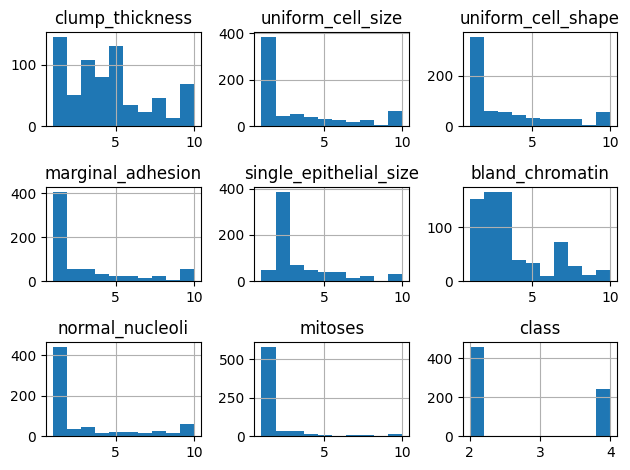

In [46]:
#EDA
plt.figure(figsize=(12,10))
df.hist()
plt.tight_layout()
plt.show()

Se puede observar que para todas las features a excepciòn de la Feature class, los valores están sesgados hacia la izquierda.Para la Feature Clump_thickness se puede observa un comportamiento bimodal

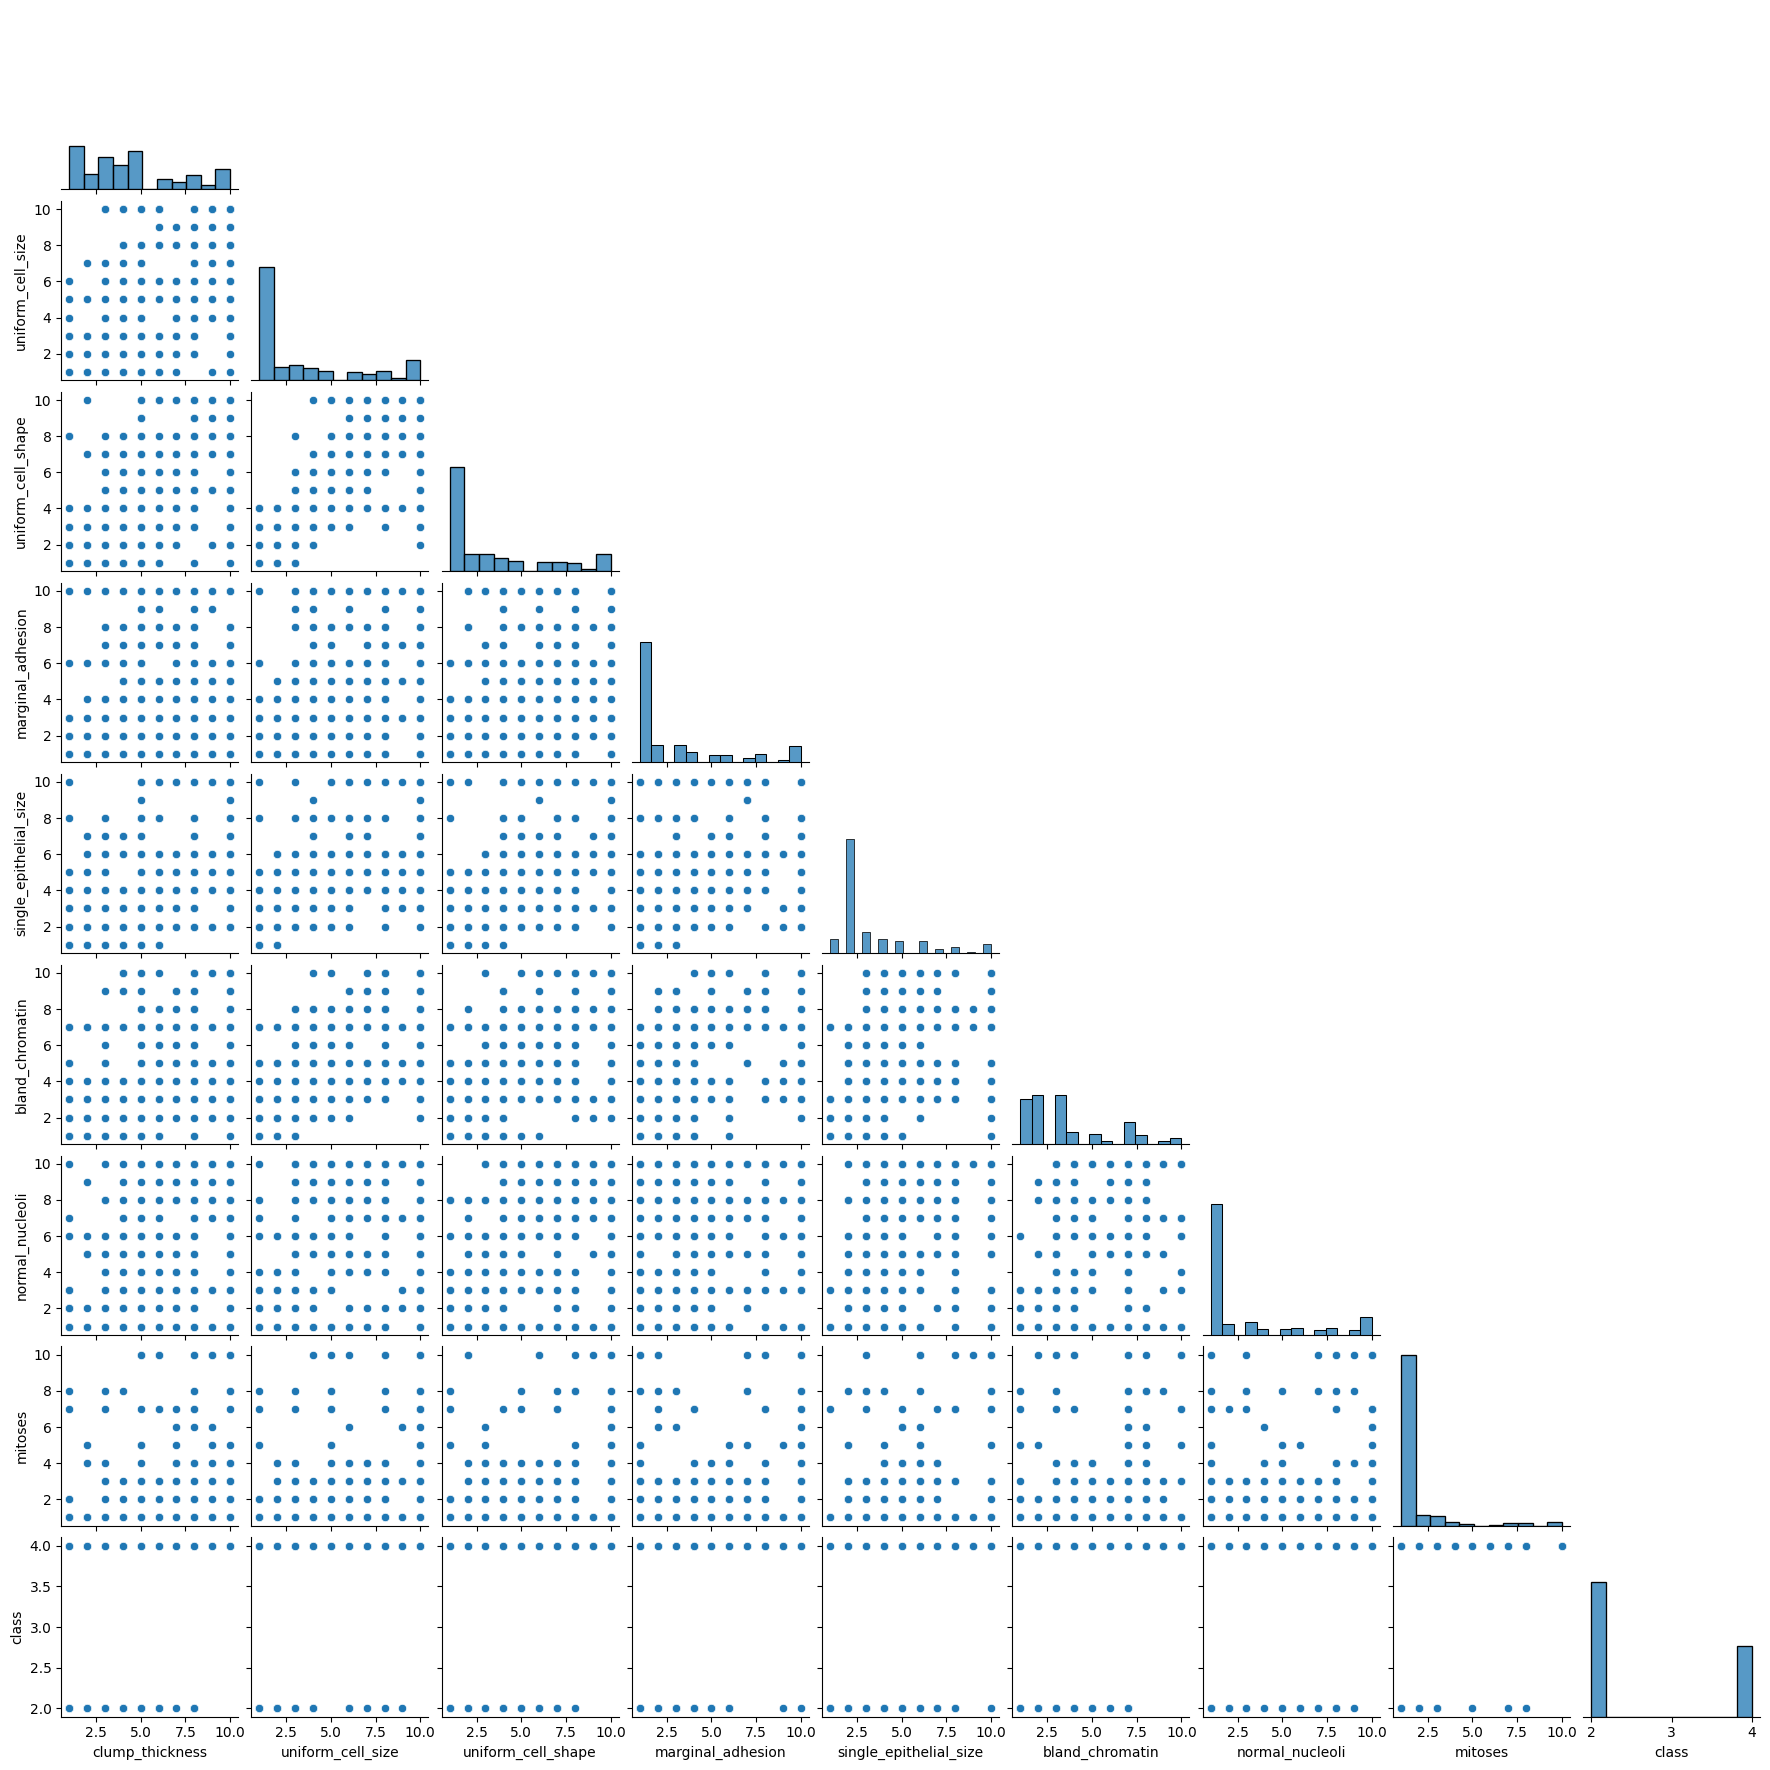

In [47]:
sns.pairplot(df, corner=True, height=2)
plt.show()

Mediane el grafico pairplot se puede observar que existe una fuerte relaciòn lineal entre las features uniform_cell_shape y uniform_cell_size. Para corrobra esto utulizamos .corr para calcular el coeficiente de correlaciòn de pearson encontrando que el mayor valor se encuentra para las features mencinadas con 0.906, pero sigue sin resultar en una fuerte relación lineal para pensar en solo dejar una de las dos o combinar las dos features para generar una sola y no crear redundancia de información.

In [48]:
R = df.iloc[:,:].corr()
column_labels = df.iloc[:,:].columns
R

,clump_thickness,uniform_cell_size,uniform_cell_shape,marginal_adhesion,single_epithelial_size,bare_nuclel,bland_chromatin,normal_nucleoli,mitoses,class
clump_thickness,1.000000,0.644913,0.654589,0.486356,0.521816,0.058134,0.558428,0.535835,0.350034,0.716001
uniform_cell_size,0.644913,1.000000,0.906882,0.705582,0.751799,0.036637,0.755721,0.722865,0.458693,0.817904
uniform_cell_shape,0.654589,0.906882,1.000000,0.683079,0.719668,0.018840,0.735948,0.719446,0.438911,0.818934
marginal_adhesion,0.486356,0.705582,0.683079,1.000000,0.599599,0.054939,0.666715,0.603352,0.417633,0.696800
single_epithelial_size,0.521816,0.751799,0.719668,0.599599,1.000000,0.055250,0.616102,0.628881,0.479101,0.682785
bare_nuclel,0.058134,0.036637,0.018840,0.054939,0.055250,1.000000,0.021273,0.007255,0.053453,0.072737
bland_chromatin,0.558428,0.755721,0.735948,0.666715,0.616102,0.021273,1.000000,0.665878,0.344169,0.756616
normal_nucleoli,0.535835,0.722865,0.719446,0.603352,0.628881,0.007255,0.665878,1.000000,0.428336,0.712244
mitoses,0.350034,0.458693,0.438911,0.417633,0.479101,0.053453,0.344169,0.428336,1.000000,0.423170
class,0.716001,0.817904,0.818934,0.696800,0.682785,0.072737,0.756616,0.712244,0.423170,1.000000


## MACHINE LEARNING

Luego de realizar la exploración de la data, en donde se analiza el tipo de datos a trabajar, la cantidad de datos faltantes en el dataset, la forma de llenado de los datos faltantes y el conocimiento de la distribución de las features y sus relaciones entre sí, se procede a generar la data de entrenamiento y de prueba para generar el mejor modelo según sea el caso, si se quiere predecir o clasificar una variable objetivo en base a las features, para este caso se iniciará dividiendo la data en training y test, y se considerará el caso si es necesario normalizar por lo que se evaluará.

In [49]:
X=df.drop('class', axis=1).values
y=df.loc[:,'class'].values

In [50]:
seed=8
scoring='accuracy'

### Training

### Modelo Normalizando la data

In [51]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_nor = scaler.fit_transform(X)

#Se divide la data 80% para entrenar los modelos y 20% para probar que tan buenos son
X_train, X_test, y_train, y_test = train_test_split(X_nor, y, test_size=0.2, random_state=42, stratify=y)

#al utilizar stratify=y lo que estamos es generando la misma proporción de etiquetas de salida para el trainin y test dataset
print(f"Proporción de clases de salida y(2,4):{round(np.bincount(y)[2]/len(y),1), round(np.bincount(y)[4]/len(y),1)},{np.bincount(y)[2],np.bincount(y)[4]}")
print(f"Proporción de clases de salida y_train(2,4):{round(np.bincount(y_train)[2]/len(y_train),1), round(np.bincount(y_train)[4]/len(y_train),1)},{np.bincount(y_train)[2],np.bincount(y_train)[4]}")
print(f"Proporción de clases de salida y_train(2,4):{round(np.bincount(y_test)[2]/len(y_test),1), round(np.bincount(y_test)[4]/len(y_test),1)},{np.bincount(y_test)[2],np.bincount(y_test)[4]}")



Proporción de clases de salida y(2,4):(0.7, 0.3),(458, 241)
Proporción de clases de salida y_train(2,4):(0.7, 0.3),(366, 193)
Proporción de clases de salida y_train(2,4):(0.7, 0.3),(92, 48)


### Training

In [52]:
#Definimos los modelos a entrenar
models=[]
models.append(('KNN',KNeighborsClassifier(n_neighbors=5)))
models.append(('SWM',svm.SVC()))

#Evaluar cada modelo 
results=[]
names=[]

for name, model in models:
    kfold=model_selection.KFold(n_splits=10,shuffle=True,random_state=seed)
    cv_results=model_selection.cross_val_score(model, X_train,y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg="%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


KNN: 0.958831 (0.034892)
SWM: 0.957013 (0.032260)


### Predictions

In [53]:
for name, model in models:
    model.fit(X_train, y_train)
    predictions=model.predict(X_test)
    print(name)
    print(accuracy_score(y_test,predictions))
    print(classification_report(y_test, predictions))


KNN
0.9571428571428572
              precision    recall  f1-score   support

           2       0.98      0.96      0.97        92
           4       0.92      0.96      0.94        48

    accuracy                           0.96       140
   macro avg       0.95      0.96      0.95       140
weighted avg       0.96      0.96      0.96       140

SWM
0.9571428571428572
              precision    recall  f1-score   support

           2       0.98      0.96      0.97        92
           4       0.92      0.96      0.94        48

    accuracy                           0.96       140
   macro avg       0.95      0.96      0.95       140
weighted avg       0.96      0.96      0.96       140



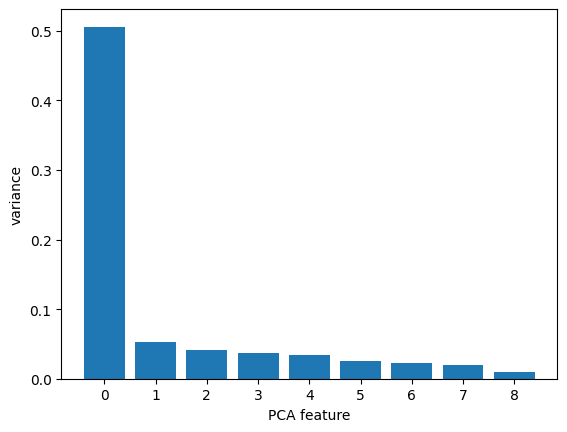

In [76]:
# Create a PCA instance: pca
pca = PCA()
# Fit the pipeline to 'samples'
pca.fit(X_train)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

### Logistic Regression

In [77]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
# Definir el modelo base
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


model = LogisticRegression(random_state=42)

# Definir los parámetros para el grid search
param_dist = {
    'penalty': ['l2'],  # Tipo de regularización
    'C': uniform(loc=0, scale=10),  # Distribución uniforme para C entre 0 y 10
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']  # Algoritmos de optimización
}

In [78]:
# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
random_search.fit(X_train_pca, y_train)

# Mejor resultado de RandomizedSearchCV
print("Mejores parámetros de RandomizedSearchCV:", random_search.best_params_)
print("Mejor puntuación de RandomizedSearchCV:", random_search.best_score_)

Mejores parámetros de RandomizedSearchCV: {'C': 9.488855372533333, 'penalty': 'l2', 'solver': 'sag'}
Mejor puntuación de RandomizedSearchCV: 0.9588642213642213


In [79]:
#Afinamos con GridSearch
from sklearn.model_selection import GridSearchCV

# Usar los mejores parámetros de RandomizedSearchCV como punto de partida
best_penalty = random_search.best_params_['penalty']
best_C = random_search.best_params_['C']
best_solver = random_search.best_params_['solver']

# Definir los parámetros para GridSearchCV alrededor de los mejores parámetros encontrados
param_grid = {
    'penalty': [best_penalty],  # Mantener el mejor tipo de regularización
    'C': [best_C / 2, best_C, best_C * 2],  # Explorar alrededor del mejor valor de C
    'solver': [best_solver]  # Mantener el mejor algoritmo de optimización
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

# Mejor resultado de GridSearchCV
print("Mejores parámetros de GridSearchCV:", grid_search.best_params_)
print("Mejor puntuación de GridSearchCV:", grid_search.best_score_)



Mejores parámetros de GridSearchCV: {'C': 9.488855372533333, 'penalty': 'l2', 'solver': 'sag'}
Mejor puntuación de GridSearchCV: 0.9588642213642213


In [80]:
from sklearn.metrics import accuracy_score, classification_report

# Predecir en el conjunto de prueba usando el mejor modelo de GridSearchCV
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_pca)

print("Accuracy de GridSearchCV:", accuracy_score(y_test, y_pred))
print("Reporte de clasificación de GridSearchCV:\n", classification_report(y_test, y_pred))

Accuracy de GridSearchCV: 0.9642857142857143
Reporte de clasificación de GridSearchCV:
               precision    recall  f1-score   support

           2       0.98      0.97      0.97        92
           4       0.94      0.96      0.95        48

    accuracy                           0.96       140
   macro avg       0.96      0.96      0.96       140
weighted avg       0.96      0.96      0.96       140



In [81]:
from sklearn.model_selection import cross_val_score

# Crear un nuevo modelo con los mejores parámetros encontrados
best_model = grid_search.best_estimator_  # o random_search.best_estimator_

# Realizar cross-validation con 5 folds
scores = cross_val_score(best_model, X_train_pca, y_train, cv=5)

# Imprimir las puntuaciones de validación cruzada
print("Puntuaciones de validación cruzada:", scores)

# Imprimir la puntuación media y la desviación estándar de las puntuaciones de validación cruzada
print("Puntuación media de validación cruzada:", scores.mean())
print("Desviación estándar de las puntuaciones de validación cruzada:", scores.std())


Puntuaciones de validación cruzada: [0.95535714 0.94642857 0.97321429 0.95535714 0.96396396]
Puntuación media de validación cruzada: 0.9588642213642213
Desviación estándar de las puntuaciones de validación cruzada: 0.009068366005695529


Estos resultados indican que el modelo tiene una precisión promedio del 95.53% en datos no observados, con una desviación estándar de aproximadamente 0.79%. Esto sugiere que el modelo es bastante consistente en su rendimiento entre diferentes pliegues de validación cruzada.

In [83]:
from matplotlib.colors import ListedColormap
#Codigo Tomado libro Raschka, S., & Mirjalili, V. (n.d.). Python Machine Learning: Aprendizaje automático y aprendizaje profundo con Python, scikit-learn y TesnorFlow (2nd ed.). MARCOMBO IMPORTACION.
#Chapter 5
def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

C:\Users\jesus\AppData\Local\Temp\ipykernel_13276\1452996162.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=X[y == cl, 0],
C:\Users\jesus\AppData\Local\Temp\ipykernel_13276\1452996162.py:24: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


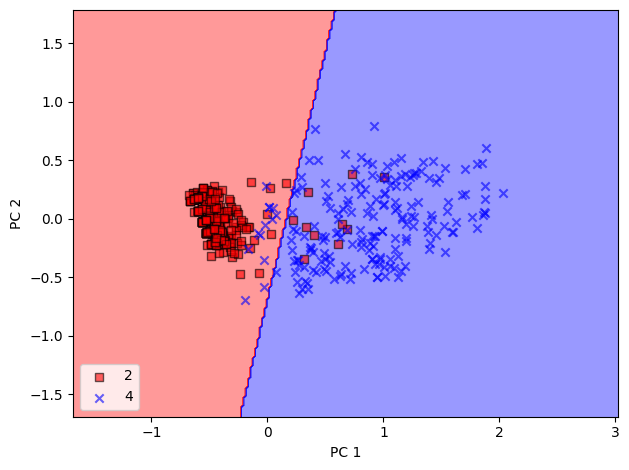

In [85]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_04.png', dpi=300)
plt.show()

C:\Users\jesus\AppData\Local\Temp\ipykernel_13276\1452996162.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=X[y == cl, 0],
C:\Users\jesus\AppData\Local\Temp\ipykernel_13276\1452996162.py:24: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


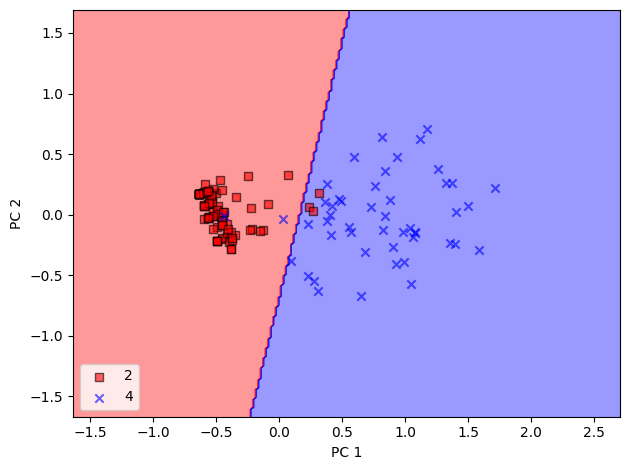

In [87]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_04.png', dpi=300)
plt.show()